## Finetune LaBSE model with your parallel corpora

tg: @lingtrain_chat

In this notebook we will finetune LaBSE model on our corpora. 

In [ ]:
# !pip install seaborn more_itertools lingtrain-aligner==0.9.4 dateparser sentence_transformers sentencepiece transformers razdel datasets

In [ ]:
# !mkdir mari

#copy example files from
#https://github.com/averkij/a-studio/tree/main/tools/labse_finetune_and_extract/mari 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
from sentence_transformers import SentenceTransformer, SentencesDataset, LoggingHandler, losses
from sentence_transformers.readers import InputExample
from sentence_transformers.evaluation import SentenceEvaluator
from torch.utils.data import DataLoader
from datetime import datetime
from transformers import AdamW, AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from tqdm import tqdm
import os
import logging
from warnings import simplefilter
import sys
from datasets import load_dataset 

from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, helper, vis_helper, metrics

sns.set_theme(style="darkgrid")

In [25]:
#configure logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
simplefilter(action="ignore", category=FutureWarning)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] - %(process)d: %(message)s",
    datefmt="%d-%b-%y %H:%M:%S",
    handlers=[
        logging.StreamHandler(sys.stdout),
        logging.FileHandler("_labse.log", mode="a"),
    ],
)
logging.getLogger("matplotlib.font_manager").disabled = True
logger = logging.getLogger(__name__)


In [26]:
def flatten(arr):
    return [x for xs in arr for x in xs]

class ChainScoreEvaluator(SentenceEvaluator):
    """Evaluate a lingtrain chain score. This score calculates coefficient of unbrokenness."""
    def __init__(self, db_path, lang_from, lang_to, text1, text2, model, scores_1=[], scores_2=[], evaluation_steps=100):
        self.db_path = db_path
        self.lang_from = lang_from
        self.lang_to = lang_to
        self.text1 = text1
        self.text2 = text2
        self.scores_1 = scores_1
        self.scores_2 = scores_2
        self.best_score = 0.0
        self.model = model
  
    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        clear_output(wait=True)
        
        text1_prepared = preprocessor.mark_paragraphs(text1)
        text2_prepared = preprocessor.mark_paragraphs(text2)

        if self.lang_from=='san':
            splitted_from = flatten([x.split('.') for x in text1_prepared])
            splitted_from = [x.strip() + '.' for x in splitted_from]
        else:
            splitted_from = splitter.split_by_sentences_wrapper(text1_prepared, self.lang_from)
        splitted_to = splitter.split_by_sentences_wrapper(text2_prepared, self.lang_to)

        logger.info(f'Splitted length: {self.lang_from} — {len(splitted_from)}, {self.lang_to} — {len(splitted_to)}')
  
        if os.path.isfile(db_path):
          os.unlink(db_path)
        aligner.fill_db(db_path, self.lang_from, self.lang_to, splitted_from, splitted_to)
        
        start_time = time.time()
  
        batch_ids = range(0,1)
        aligner.align_db(db_path,
                        model_name='_',
                        batch_size=500,
                        window=50,             #tweak this parameter if needed
                        batch_ids=batch_ids,
                        save_pic=False,
                        embed_batch_size=100,
                        normalize_embeddings=True,
                        show_progress_bar=False,
                        shift=0,              #tweak this parameter if needed
                        model=self.model
                        )

        conflicts, rest = resolver.get_all_conflicts(db_path, min_chain_length=2, max_conflicts_len=6, batch_id=-1)
        logger.info(f'Resolving short conflicts for proper validation: {len(conflicts)} conflicts detected (min chains len are from 2 to 6).')
        resolver.resolve_all_conflicts(db_path, conflicts, model_name="_", show_logs=False, model=self.model)
        score_1 = metrics.chain_score(db_path)
        score_2 = metrics.chain_score(db_path, mode='both')
        logger.info(f"Epoch: {epoch} steps: {steps}.")
        
        if score_1 > self.best_score:
            self.best_score = score_1
            logger.info(f"Score 1: {score_1} new best score (#1).")
            if self.best_score > 0.06:
                logger.info("Saving the model...")
                model.save(f'output/best_model_{LANG_1}_{LANG_2}')
                logger.info(f"Model saved to output/best_model_{LANG_1}_{LANG_2}.")
        else:
            logger.info(f"score 1: {score_1}")
  
        logger.info(f"score 2: {score_2}")
        self.scores_1.append(score_1)
        self.scores_2.append(score_2)
  
        vis_helper.visualize_alignment_by_db(db_path,
                output_path="./img_alignment/alignment_vis_mari.png",
                batch_size=400,
                size=(600,600),
                lang_name_from=self.lang_from,
                lang_name_to=self.lang_to,
                plt_show=True)

        # fig, ax=plt.subplots(1,2, figsize=(18, 5))
        
        if steps % evaluation_steps==0:
            sns.lineplot(data=self.scores_1)

        # if steps % evaluation_steps==0:
        #     sns.lineplot(data=self.scores_2, ax=ax[1])
  
        return score_1

### Prepare dataset

In [27]:
#lang codes in our experiment
LANG_1 = 'mhr'
LANG_2 = 'ru'

#columns in dataset
DATASET_LANG_1 = 'mhr'
DATASET_LANG_2 = 'rus'

ds = load_dataset('AigizK/mari-russian-parallel-corpora', split='train')

def prepare_dataset(ds, feature_1, feature_2):
    res = []
    for item in ds:
        res.append({LANG_1:item[feature_1], LANG_2:item[feature_2]})
    return res
        
train_dataset_orig = prepare_dataset(ds, feature_1=DATASET_LANG_1, feature_2=DATASET_LANG_2)

In [17]:
train_dataset_orig[111]

{'mhr': 'Мардеж толашыме годым мыйын вуйышкем икте почеш весе, неле шонымаш-шамыч толын пурат.',
 'ru': 'В голове, под шум бури, поднимались и летели одна за другой тяжелые мысли.'}

### Load original model

In [18]:
model = SentenceTransformer('LaBSE')

05-Feb-24 17:18:38 [INFO] - 23990: Load pretrained SentenceTransformer: LaBSE
05-Feb-24 17:18:40 [INFO] - 23990: Use pytorch device: cuda


### Prepare tests and finetune the model

Texts should be clean and equal in terms of sense.

In [28]:
# scores = []
db_path = f"alignment_{LANG_1}.db"
evaluation_steps = 100

text1_input = "mari/artamonov_mhr.txt"
text2_input = "mari/artamonov_ru.txt"

with open(text1_input, "r", encoding="utf8") as input1:
    text1 = input1.readlines()
with open(text2_input, "r", encoding="utf8") as input2:
    text2 = input2.readlines()
    
evaluator = ChainScoreEvaluator(db_path, LANG_1, LANG_2, text1, text2, model=model, evaluation_steps=evaluation_steps)

In [30]:
num_epochs = 1
train_batch_size = 8
warmup_steps = 1000

train_examples = [InputExample(texts=[x[LANG_1], x[LANG_2]], label=1.0) for x in train_dataset_orig]
train_dataset = SentencesDataset(train_examples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.MultipleNegativesRankingLoss(model=model)

07-Feb-24 14:16:21 [INFO] - 23990: Splitted length: mhr — 627, ru — 425
07-Feb-24 14:16:21 [INFO] - 23990: Initializing database alignment_mhr.db
Aligning without segments.
tasks amount: 1
batch: 0 (0)
07-Feb-24 14:16:22 [INFO] - 23990: Batch 0. Calculating vectors.
07-Feb-24 14:16:23 [WARNING] - 23990: can not fetch index db
get_all_conflicts, handle_start: False handle_finish: False batch_id -1
conflicts to solve: 32
total conflicts: 58
07-Feb-24 14:16:23 [INFO] - 23990: Resolving short conflicts for proper validation: 32 conflicts detected (min chains len are from 2 to 6).



100%|██████████| 32/32 [00:01<00:00, 18.14it/s]


07-Feb-24 14:16:25 [INFO] - 23990: Epoch: 0 steps: -1.
07-Feb-24 14:16:25 [INFO] - 23990: Score 1: 0.384133611691023 new best score (#1).
07-Feb-24 14:16:25 [INFO] - 23990: Saving the model...
07-Feb-24 14:16:25 [INFO] - 23990: Save model to output/best_model_mhr_ru_3
07-Feb-24 14:16:29 [INFO] - 23990: Model saved to output/best_model_mhr_ru_3.
07-Feb-24 14:16:29 [INFO] - 23990: score 2: 0.6986721144024515


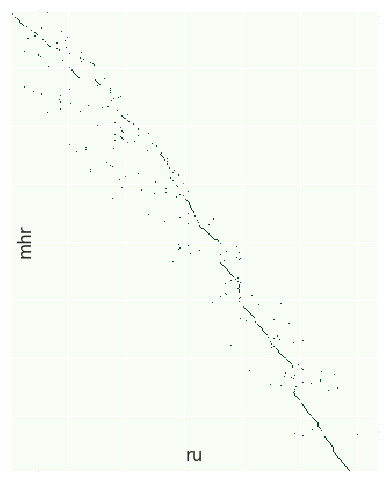

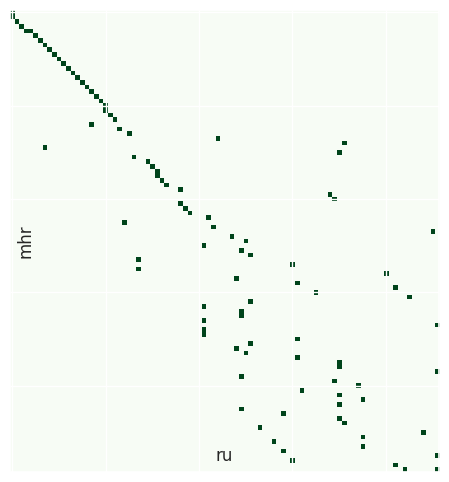

In [31]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=evaluation_steps,
          save_best_model=False,
          use_amp=True,
          warmup_steps=warmup_steps,
          scheduler = 'warmupcosine',
          optimizer_params = {'lr': 2e-5}, # default 2e-5   #3e-4
          )

## Upload finetuned model to HF

In [14]:
from huggingface_hub import HfApi

# https://huggingface.co/settings/tokens
api = HfApi(token="your_hf_token")

api.create_repo(
    repo_id="lingtrain/labse-mari",
    repo_type='model',
    exist_ok=True
)

api.upload_folder(
    repo_id="lingtrain/labse-mari",
    folder_path="./output/best_model_mhr_ru",
    repo_type="model",
)

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/lingtrain/labse-mari/commit/f9715ea770b3376987c38562050a4399e3757179', commit_message='Upload folder using huggingface_hub', commit_description='', oid='f9715ea770b3376987c38562050a4399e3757179', pr_url=None, pr_revision=None, pr_num=None)

## Load model from HF

In [32]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('lingtrain/labse-mari')

07-Feb-24 14:18:00 [INFO] - 23990: Load pretrained SentenceTransformer: lingtrain/labse-mari
07-Feb-24 14:18:01 [INFO] - 23990: Use pytorch device: cuda
